In [1]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
df = pd.read_csv('Mumbai1.csv')
df.rename(columns = {'Unnamed: 0':'ID'}, inplace = True)

In [3]:
df.head()

,ID,Price,Area,Location,No. of Bedrooms,New/Resale,Gymnasium,Lift Available,Car Parking,Maintenance Staff,24x7 Security,Children's Play Area,Clubhouse,Intercom,Landscaped Gardens,Indoor Games,Gas Connection,Jogging Track,Swimming Pool
0,0,4850000,720,Kharghar,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0
1,1,4500000,600,Kharghar,1,0,1,1,1,1,1,0,1,0,0,0,0,1,1
2,2,6700000,650,Kharghar,1,0,1,1,1,1,1,1,1,1,0,0,0,1,1
3,3,4500000,650,Kharghar,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0
4,4,5000000,665,Kharghar,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0


## Описательная статистика датасета

In [4]:
price_stat = {"min": df["Price"].min(), 
            "max": df["Price"].max(), 
            "mean": df["Price"].mean(),
            "median": df["Price"].median(),
            "mode": df["Price"].mode().to_list(),
            "var": df["Price"].var(ddof=0),
            "std": df["Price"].std(ddof=0),
            "range": df["Price"].max() - df["Price"].min(),
            "interquartile_range": df["Price"].quantile(0.75) - df["Price"].quantile(0.25),
            "skew": df["Price"].skew()
            }
price_stat

{'min': 2000000,
 'max': 420000000,
 'mean': 15154013.68725382,
 'median': 9500000.0,
 'mode': [8500000],
 'var': 406338439719420.7,
 'std': 20157838.170781624,
 'range': 418000000,
 'interquartile_range': 12200000.0,
 'skew': 6.823590994567408}

In [5]:
df.head()

,ID,Price,Area,Location,No. of Bedrooms,New/Resale,Gymnasium,Lift Available,Car Parking,Maintenance Staff,24x7 Security,Children's Play Area,Clubhouse,Intercom,Landscaped Gardens,Indoor Games,Gas Connection,Jogging Track,Swimming Pool
0,0,4850000,720,Kharghar,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0
1,1,4500000,600,Kharghar,1,0,1,1,1,1,1,0,1,0,0,0,0,1,1
2,2,6700000,650,Kharghar,1,0,1,1,1,1,1,1,1,1,0,0,0,1,1
3,3,4500000,650,Kharghar,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0
4,4,5000000,665,Kharghar,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0


## Посмотрим зависимость цены, от площади (обязательно ли чем больше площадь, тем больше цена)

Text(0.5, 1.0, '   Зависимость цены от площади')

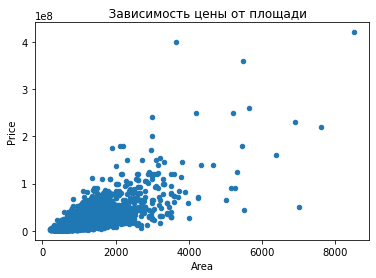

In [6]:
df.plot(x = 'Area', y = 'Price', kind = 'scatter')
plt.title("   Зависимость цены от площади")

Точек слишком много, но общая тенденция прослеживается

In [7]:
loc_data = {location: df["Location"].to_list().count(location) for location in set(df["Location"])}
loc_df = pd.DataFrame.from_dict(data=loc_data, orient="index", columns=["Location"]).sort_values(by = ['Location'])
loc_df.shape

(413, 1)

## Возможно рассмотреть все локации одновременно

Text(0.5, 1.0, 'Все районы и количесвто домов (нечитабельная диаграмма)')

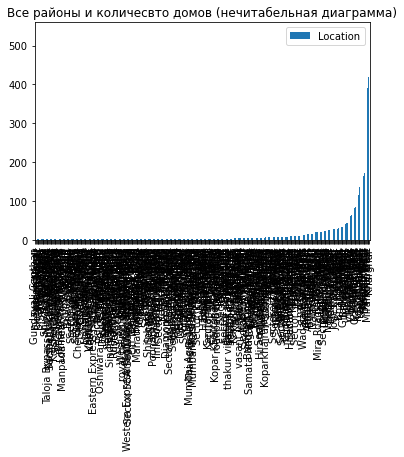

In [9]:
loc_df.plot.bar()
plt.title("Все районы и количесвто домов (нечитабельная диаграмма)")

Видим, что локаций слишком много, поэтому оставим только топ 20

Text(0.5, 1.0, 'Топ 20 районов по кол-ву домов')

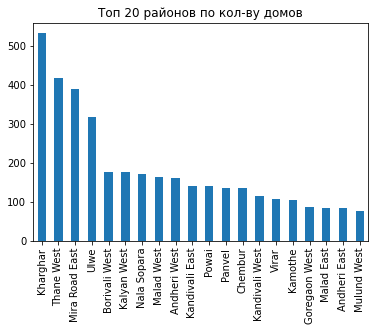

In [8]:
location = df['Location'].value_counts().head(20)
location.plot.bar()
plt.title("Топ 20 районов по кол-ву домов")

Больше всего информации есть о топ4 районах, поэтому рассмотрим их

In [9]:
#выборка топ 4 отдельных районов
most_df = df.loc[(df["Location"] == "Kharghar")| (df["Location"] == "Thane West")
               | (df["Location"] == "Mira Road East")|(df["Location"] == "Ulwe")]
most_num = most_df.shape[0]
print('Количество домов в Kharghar, Thane West, Mira Road East и Ulwe :',most_num,
     '\nПроцент охватываемых домов', most_df.shape[0]/df.shape[0]*100)

Количество домов в Kharghar, Thane West, Mira Road East и Ulwe : 1660 
Процент охватываемых домов 26.154088545769653


## Чем больше площадь, тем больше цена дома

Text(0.5, 1.0, '   Зависимость цены от площади в выборке')

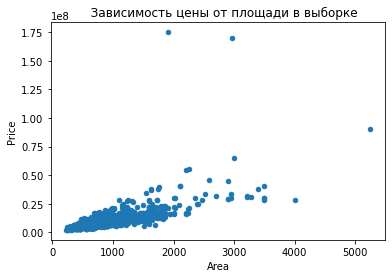

In [10]:
most_df.plot(x = 'Area', y = 'Price', kind = 'scatter')
plt.title("   Зависимость цены от площади в выборке")

Гипотеза подтвердилась, есть несколько выбросов, возможно это дома с полным комплектом услуг

## Соотношение кол-ва домов по отдельным характеристикам

In [120]:
#функция вывода столбиковой дианграмм для характеристик домов
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 3]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (10 * nGraphPerRow, 12 * nGraphRow), dpi = 300, facecolor = 'w', edgecolor = 'k')
    for i in range(1, min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.title(f'{columnNames[i]}')
        plt.xticks(np.arange(2), ('No', 'Yes'))
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
plotPerColumnDistribution(most_df, 14, 5)

<ipython-input-120-53e93178fa63>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i)


## Чем больше количество комнат, тем выше цена

([<matplotlib.axis.XTick at 0x19b927111c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

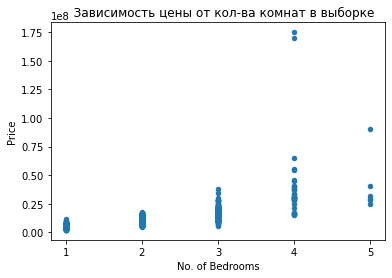

In [12]:
most_df.plot(x = 'No. of Bedrooms', y = 'Price', kind = 'scatter')
plt.title("   Зависимость цены от кол-ва комнат в выборке")
plt.xticks([1, 2, 3, 4, 5])

Гипотеза подтвердилась, причем самую большую цену имеют 4комнатные квартиры

In [13]:
old_df = most_df.loc[most_df["New/Resale"] == 0]
old_num = old_df.shape[0]
new_df = most_df.loc[most_df["New/Resale"] == 1]
new_num = new_df.shape[0]
newold_df = pd.DataFrame({"": [old_num, new_num]},
                       index=["Resale", "New"])

## Новых домов меньше чем старых

Text(0.5, 1.0, 'Соотношение новых и перепроданных домов')

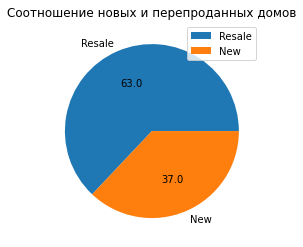

In [14]:
newold_df.plot.pie(y='', autopct="%.1f")
plt.title("Соотношение новых и перепроданных домов")

## Цена на новые дома в выборке растет быстрее, чем на старые

(0.0, 5300.0)

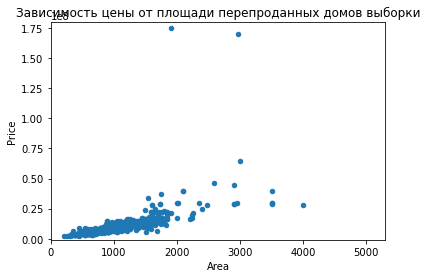

In [15]:
old_df.plot(x = 'Area', y = 'Price', kind = 'scatter')
plt.title("Зависимость цены от площади перепроданных домов выборки")
plt.ylim([-1000000, 180000000])
plt.xlim([0, 5300])

(0.0, 5300.0)

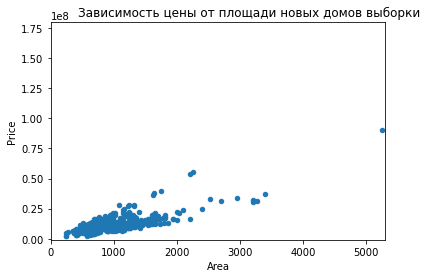

In [16]:
new_df.plot(x = 'Area', y = 'Price', kind = 'scatter')
plt.title("                Зависимость цены от площади новых домов выборки")
plt.ylim([-1000000, 180000000])
plt.xlim([0, 5300])

Явно не видно, что новые дома с той же площадью, в основном, дороже чем перепроданные

## Зависимость цены дома от всех характеристик

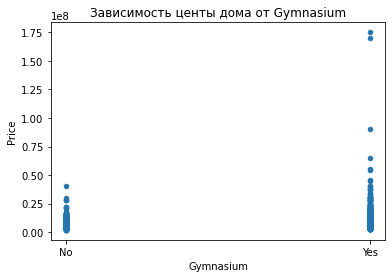

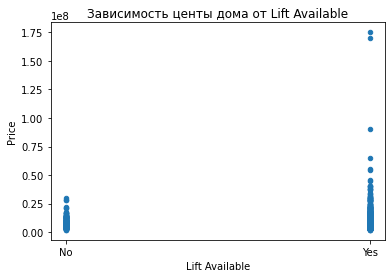

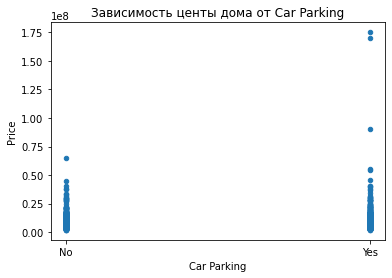

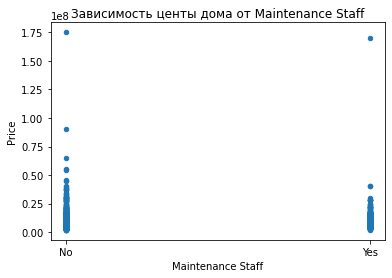

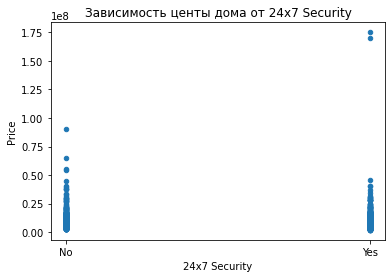

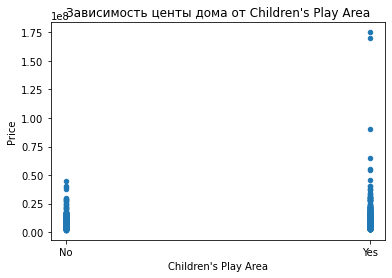

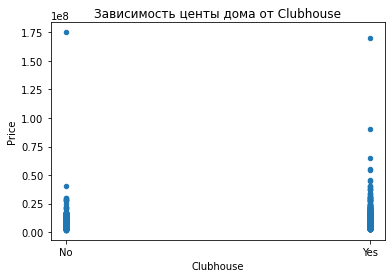

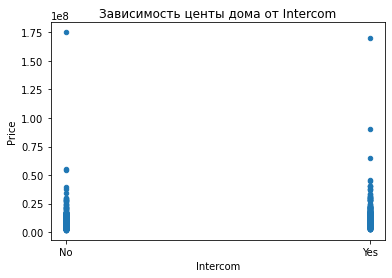

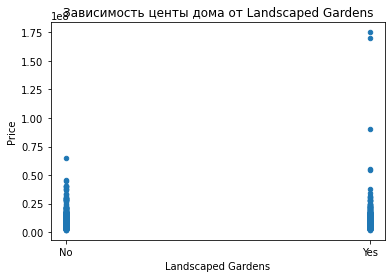

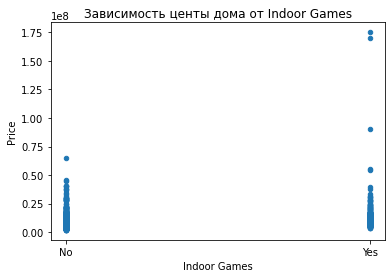

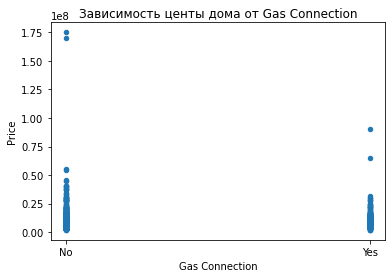

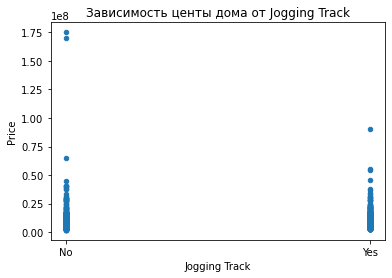

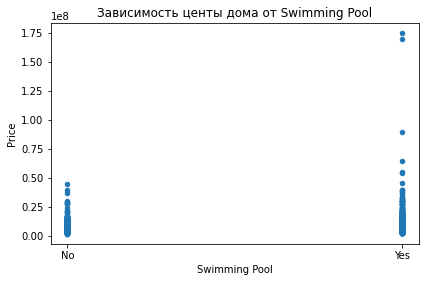

In [117]:
def plotPrice(df, nGraphShown):
    nunique = df.nunique()

    nRow, nCol = df.shape
    columnNames = list(df)
    for i in range(6, min(nCol, nGraphShown)):

        df.plot.scatter(x = f'{columnNames[i]}', y = f'{columnNames[1]}')
        plt.ylabel('Price')
        plt.title(f'Зависимость центы дома от {columnNames[i]}')
        plt.xticks(np.arange(2), ('No', 'Yes'))
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
plotPrice(most_df, 19)

## Дома с бассейном больше по площади

Text(0.5, 1.0, 'Зависимость площади от наличия или отсутствия бассейнов в домах выборки')

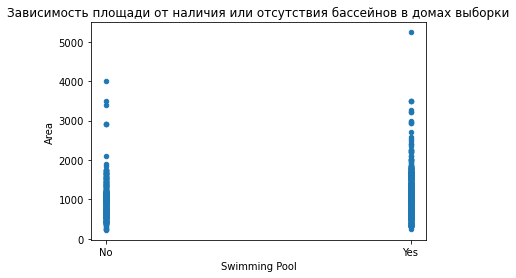

In [19]:
most_df.plot(x = 'Swimming Pool', y = 'Area', kind = 'scatter')
plt.xticks(np.arange(2), ('No', 'Yes'))
plt.title("Зависимость площади от наличия или отсутствия бассейнов в домах выборки")

# Возможно, что расматривались дома определенной ценовой категории

(0.0, 80000000.0)

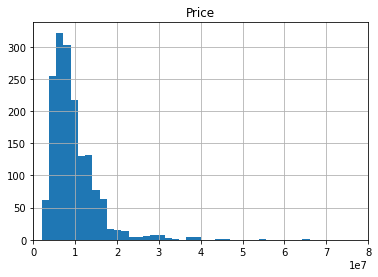

In [107]:
most_df.hist(column = 'Price', bins = 100)
plt.xlim([0, 80000000])

In [21]:
q1 = most_df["Price"].quantile(0.25)
q2 = most_df["Price"].quantile(0.5)
q3 = most_df["Price"].quantile(0.75)

(0.0, 80000000.0)

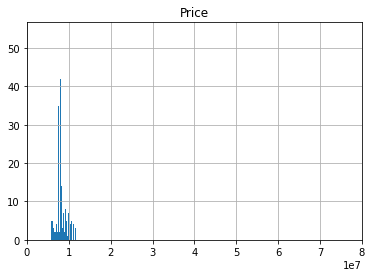

In [108]:
df_inter = most_df.query("@q1 <= Price <= @q3")
df_inter.hist(column = 'Price', bins= 100)
plt.xlim([0, 80000000])

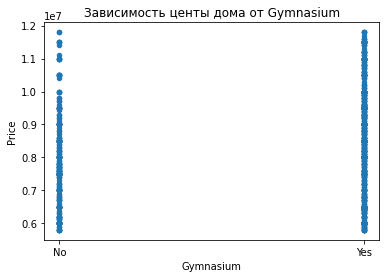

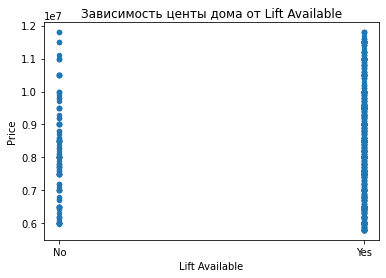

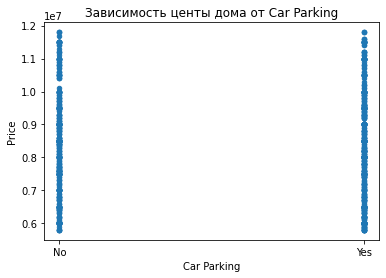

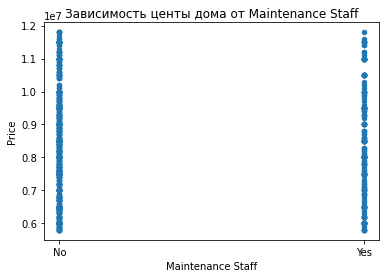

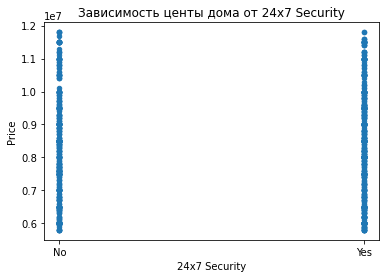

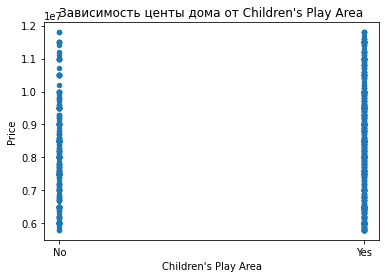

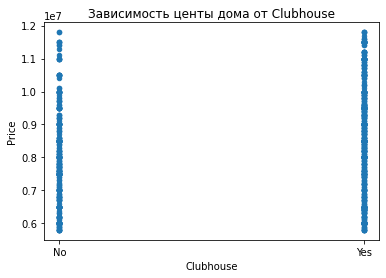

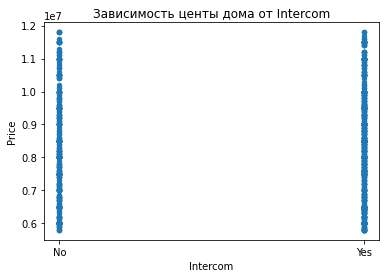

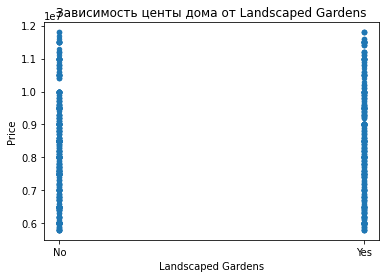

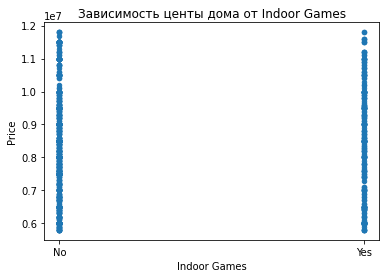

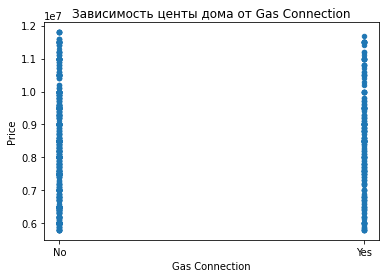

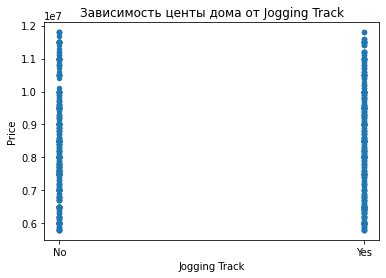

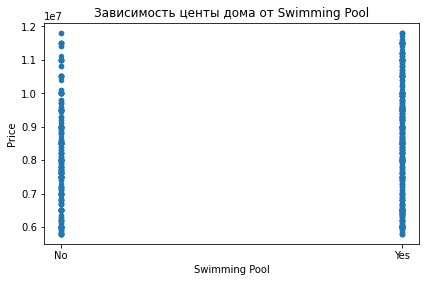

In [118]:
plotPrice(df_inter, 19)